# Определение стоимости автомобилей

## Введение

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель работы:**  
Построить модель для определения стоимости автомобиля по набору признаков.

**Задачи, решаемые в рамках работы:**  
1. Предобработка данных (устранение пропусков, аномалий).
2. Исследовательский анализ данных.
3. Корреляционный анализ данных.
4. Построение моделей.
5. Анализ работы моделей.

**План работы:**  
1. Загрузить данные.
2. Устранить пропуски, аномалии.
3. Провести исследовательский анализ данных.
4. Рассчитать корреляции между признаками.
5. Построить модели и выбрать лучшую.
6. Проанализировать работу моделей.

**Описание предоставленных данных:**  
Предоставлен один датасет со следующими признаками:
- DateCrawled — дата скачивания анкеты из базы  
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  
- Price — цена (евро) - целевой признак.

**Оценка качества обучения модели:**  
Качество обучения модели будет определяться по метрике RMSE. Она должна быть не более 2500.

## Подготовка данных

### Загрузка библиотек и функций

Сперва установим загрузим нужные библиотеки

In [ ]:
!pip install phik -q
!pip install lightgbm -q
!pip install scikit-learn==1.5.0 -q

In [ ]:
# Стандартные библиотеки
import pandas as pd
import numpy as np
import re

# Библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns


# Библиотеки для анализа данных
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px

# Библиотеки для работы с моделями
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Библиотеки для обработки ошибок
import os

# Библиотеки для подсчета времени
from time import time

Подготовим нужные функции:

In [ ]:
def lunge_analysis(df, columns, groups, hue):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов и с группировкой по одному категориальному признаку.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.
        groups: столбец из датафрейма с категориальными значениями.
        hue: признак, которые подсвечивает группы в количественных графиках.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, hue=hue, bins=20, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()
    for group in groups:
        f, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax_3 = plt.pie(df[group].value_counts(), labels=df[group].value_counts()
                       .index.tolist(), colors=sns.color_palette('bright'), autopct='%.0f%%')
        plt.title(f'Круговая диаграмма для признака {group}')
        plt.show()

In [ ]:
# Функция ищет дубликаты в датафрейме и выводит уникальные значения по заданным столбцам.
def search_duplicate(df, columns):
    print(f'Количество полных дубликатов в датафрейме:{df.duplicated().sum()}')
    for column in columns:
        print(f'Уникальные значения в столбце {column}: {df[column].unique()}')

In [ ]:
# Функция заменяет значения в столбце repaired на основании столбца price.
def replace_repaired(df):
    if df['price'] <= 1500:
        df['repaired'] = df['repaired'].replace('unknown', 'yes')
    return df

In [ ]:
# Функция заменяет значения в столбце repaired на основании столбца kilometer
def replace_repaired_kilometer(df):
    if df['kilometer'] < 20000:
        df['repaired'] = df['repaired'].replace('unknown', 'no')
    return df

In [ ]:
# Функция заменяет значения в столбце model на основании наличия модели в списке популярных.
def replace_popular_cars(df):
    if df['model'] not in popular_cars:
        df['model'] = 'other'
    return df

In [ ]:
# Функция заменяет значения в столбце brand на основании наличия бренда в списке популярных.
def replace_popular_brand(df):
    if df['brand'] not in popular_brand:
        df['brand'] = 'other'
    return df

Установим сразу константы:

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка и осмотр данных

In [ ]:
pth = '/datasets/autos.csv'

if os.path.exists(pth):
    primary_data = pd.read_csv(pth)
else:
    print('Something is wrong')

In [ ]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
primary_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Из данных видно:
1. Типы данных, кроме дат, определились правильно.
2. В столбцах VehicleType, Gearbox, Model, FuelType, Repaired есть пропуски.   

В целях поддержания аккуратности и чтобы не ошибиться в дальнейшем при написании кода переименуем столбцы.

In [ ]:
rename_columns = {
    'DateCrawled' : 'date_crawled',
    'Price' : 'price',
    'VehicleType' : 'vehicle_type',
    'RegistrationYear' : 'registration_year',
    'Gearbox' : 'gearbox',
    'Power' : 'power',
    'Model' : 'model',
    'Kilometer' : 'kilometer',
    'RegistrationMonth' : 'registration_month',
    'FuelType' : 'fuel_type',
    'Brand' : 'brand',
    'Repaired' : 'repaired',
    'DateCreated' : 'date_created',
    'NumberOfPictures' : 'number_of_pictures',
    'PostalCode' : 'postal_code',
    'LastSeen' : 'last_seen'
}

In [ ]:
primary_data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in primary_data.columns]

In [ ]:
primary_data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [ ]:
primary_data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переименовано.

### Проверка на дубликаты

Проверим наличие дубликатов, полных, явных и не явных. Для этого воспользуемся функцией. Сперва сформируем перечень столбцов, где могут быть неявные дубликаты.

In [ ]:
duplicate_columns = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'brand',
    'repaired'
]

In [ ]:
search_duplicate(primary_data, duplicate_columns)

Количество полных дубликатов в датафрейме:4
Уникальные значения в столбце vehicle_type: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в столбце gearbox: ['manual' 'auto' nan]
Уникальные значения в столбце model: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicent

Как видно, в данных есть полные дубликаты, но их мало, всего 4. Также видно, что есть неявные дубликаты в столбце с типом топлива: petrol и gasoline, которые по сути являются обозначениями бензина. Кроме того, есть lpg и cng, которые представляют собой газ. Их нужно будет исправить в дальнейшем. Сейчас удалим сразу полные дубликаты:

In [ ]:
primary_data = primary_data.drop_duplicates(ignore_index = True)

Теперь приведём названия типов топлива к одним категориям.

In [ ]:
primary_data['fuel_type'] = primary_data['fuel_type'].replace('gasoline', 'petrol')
primary_data['fuel_type'] = primary_data['fuel_type'].replace(['lpg', 'cng'], 'gas')

Дубликаты удалили.

### Заполнение пропусков

Начнем заполнять пропуски со столбца VehicleType. Одна и та же модель может выпускать в разных кузовах, следовательно правильно заменить нет возможности. Поэтому воспользуемся заглушкой "unknown".

In [ ]:
primary_data['vehicle_type'] = primary_data['vehicle_type'].fillna('unknown')

Теперь обработаем столбец Model. Установить модель тоже одназначно нельзя, но можем определить марку модели. Перенесем марку машины в столбец с моделью:

In [ ]:
primary_data['model'] = primary_data['model'].fillna(primary_data['brand'])

Теперь попробуем заполнить пропуски в столбцах с коробками. Посмотрим, какие типы коробок встречаются для каждой машины:

In [ ]:
primary_data.groupby(by='model')['gearbox'].unique()

model
100        [nan, manual, auto]
145              [manual, nan]
147        [manual, nan, auto]
156        [manual, nan, auto]
159        [manual, auto, nan]
                  ...         
yaris      [manual, auto, nan]
yeti       [manual, auto, nan]
ypsilon    [manual, nan, auto]
z_reihe    [manual, auto, nan]
zafira     [manual, auto, nan]
Name: gearbox, Length: 290, dtype: object

Как видно, лишь для одной и тоже модели коробка может быть как ручная, так и автоматическая. Однозначно заполнить тоже не получиться, поэтому придётся заполнить заглушкой:

In [ ]:
primary_data['gearbox'] = primary_data['gearbox'].fillna('unknown')

Теперь посмотрим, какие есть варианты в стобце с топливом для каждой модели:

In [ ]:
primary_data.groupby(by='model')['fuel_type'].unique()

model
100                [petrol, nan, gas]
145                     [petrol, nan]
147                [petrol, nan, gas]
156                [petrol, gas, nan]
159                     [nan, petrol]
                      ...            
yaris           [petrol, nan, hybrid]
yeti                    [petrol, nan]
ypsilon            [petrol, nan, gas]
z_reihe            [petrol, nan, gas]
zafira     [petrol, gas, nan, hybrid]
Name: fuel_type, Length: 290, dtype: object

Видно, что для одной и той же машины могут использоваться разные варианты топлива. Поэтому установить однозначно, какой вариант топлива в том или ином случае не получиться. В связи с этим используем заглушку.

In [ ]:
primary_data['fuel_type'] = primary_data['fuel_type'].fillna('unknown')

Такая же ситуация со столбцов о ремонте. Заполним заглушкой.

In [ ]:
primary_data['repaired'] = primary_data['repaired'].fillna('unknown')

Проверим результат:

In [ ]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             354365 non-null  object
 5   power               354365 non-null  int64 
 6   model               354365 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           354365 non-null  object
 10  brand               354365 non-null  object
 11  repaired            354365 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes:

Все пропуски заполнены.

### Исследовательский анализ данных

Теперь попробуем проанализировать значения в столбцах. Сперва выделим отдельно количественные признаки и качественные признаки:

In [ ]:
num_columns = ['price',
              'registration_year',
               'power',
               'kilometer',
               'registration_month',
               'number_of_pictures'
              ]

In [ ]:
cat_columns = ['vehicle_type',
               'gearbox',
               'model',
               'fuel_type',
               'brand',
               'repaired'
              ]

Теперь посмотрим графики:

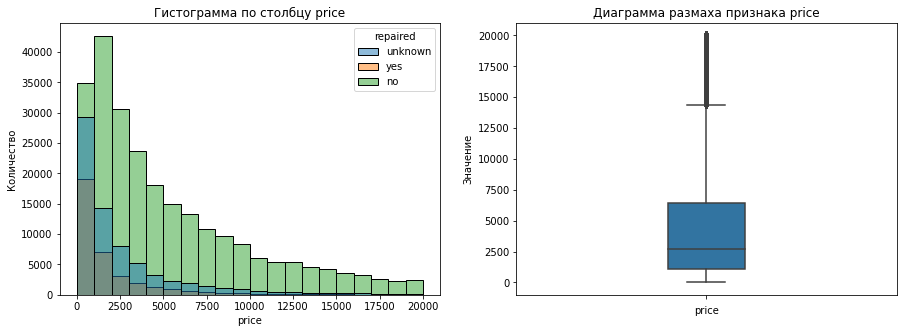

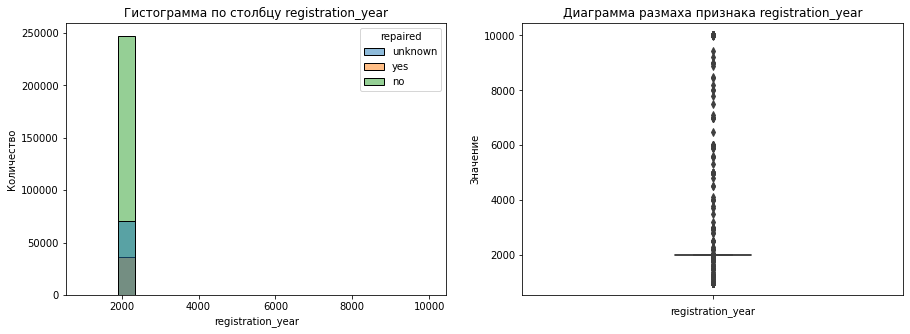

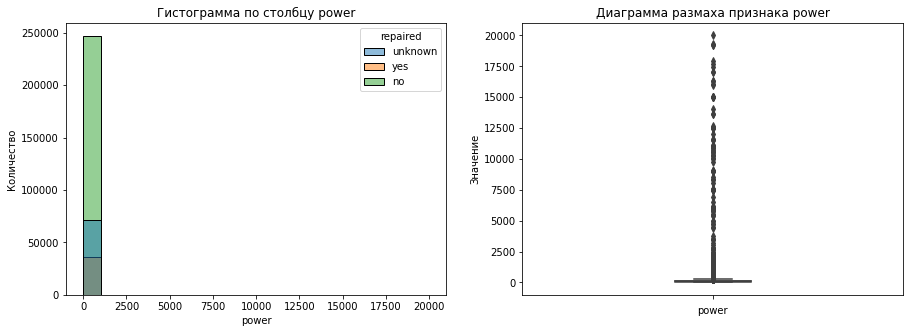

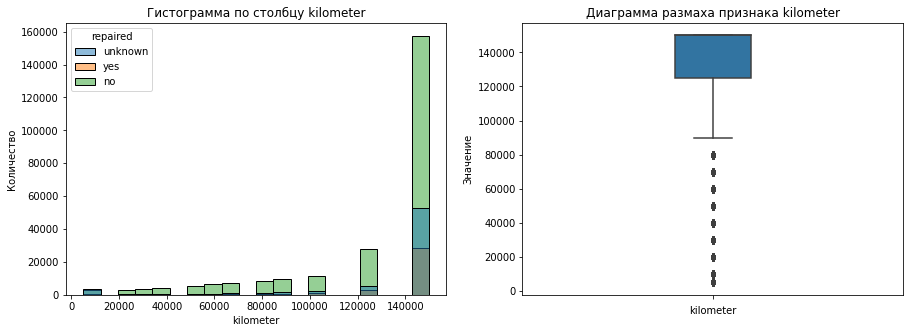

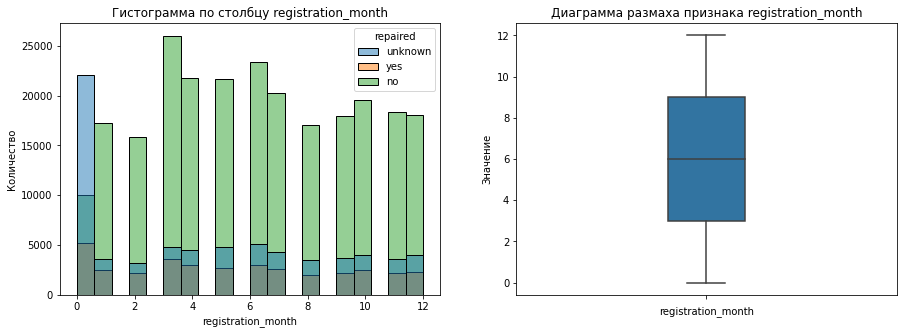

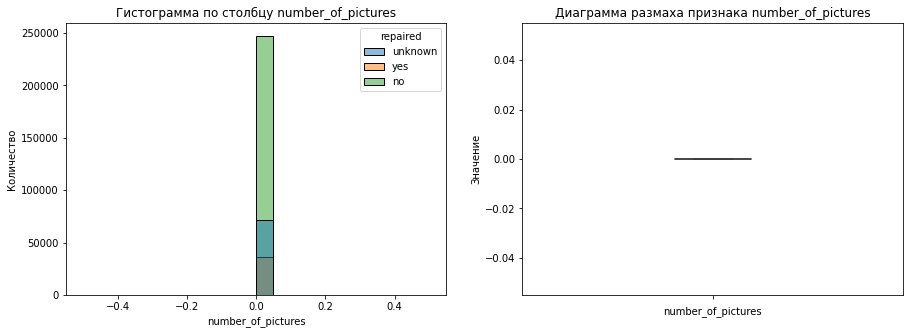

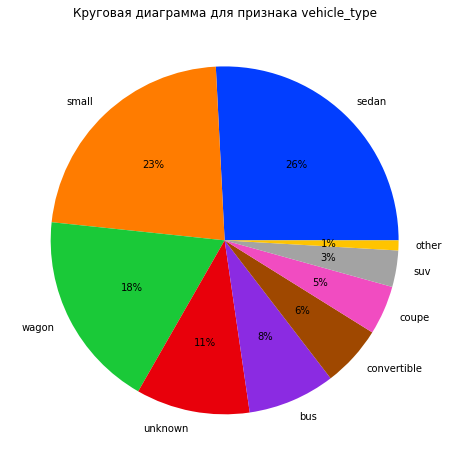

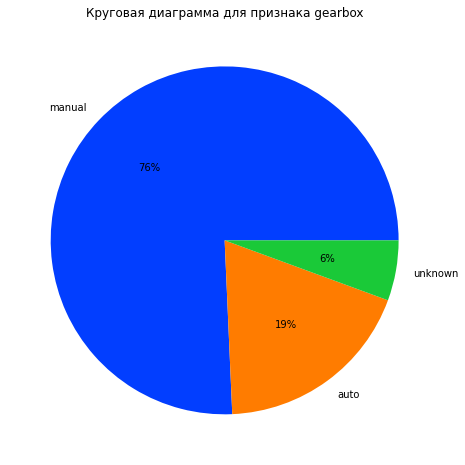

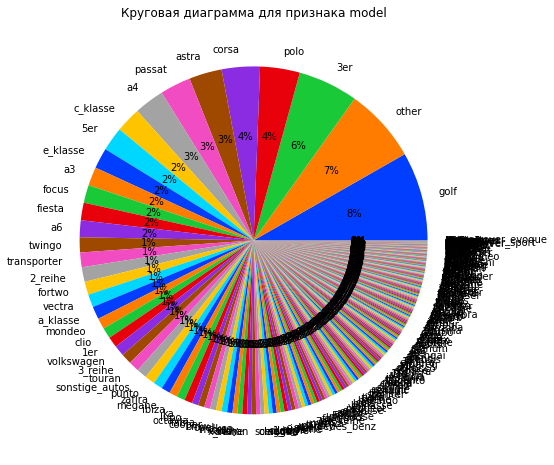

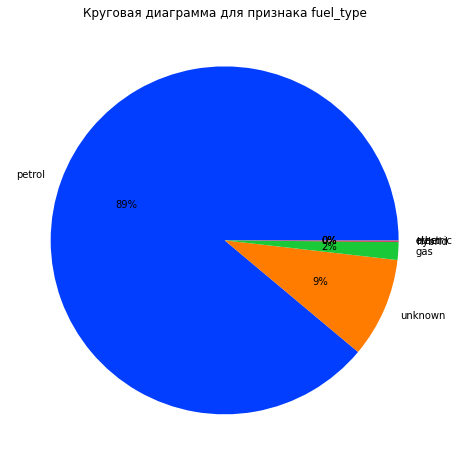

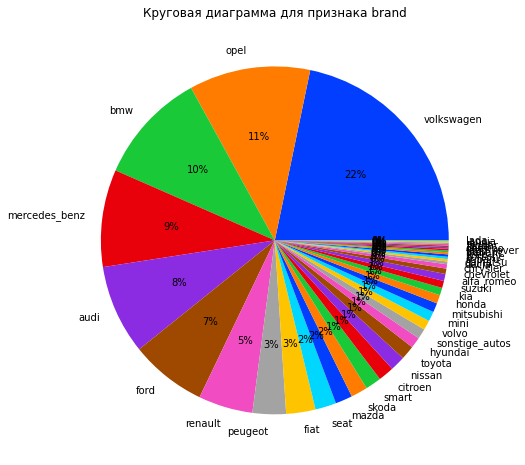

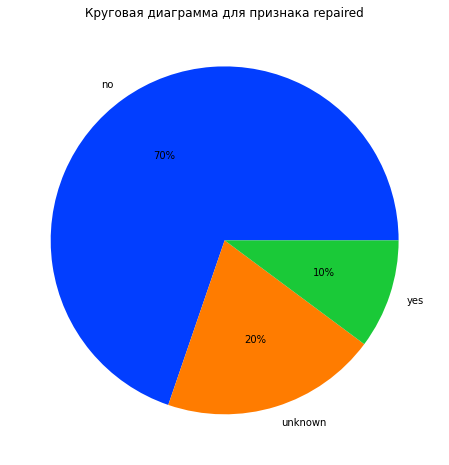

In [ ]:
lunge_analysis(primary_data, num_columns, cat_columns, 'repaired')

Из диаграмм видно следующее:
1. Есть большое количество машин, цена на которые можно признать аномально высокой (больше размаха в боксплоте).
2. Для машин, чья цена стремиться к нулю, большое количество тех, кто проходил ремонт и тех, для кого неизвестен факт ремонта. Скорее всего, не будет ошибкой, если в этом ценовом диапазоне для машин, чей статус неизвестен, присвоить статус ремонтной.
3. С столбце с годом регистрации есть очень странные значения. Так, встречается даже цифра в 10 000, что очевидно, ошибочно. Необходимо такие значения выкинуть, так как мы не знаем точного года и рассчитать его нельзя.
4. В столбце power также есть странные значения. Мощность некоторых машин достигает 20 000. Вероятно, в стоблце указана мощность в разных единицах измерений. К счастью, таких значений не много и их можно исключить.
5. В стоблце kilometer для машин с небольшим пробегом указано, что их статус ремонта неизвестен. Скорее всего они не ремонтировались, поэтому статус можно изменить соответственно.
6. В этом же столбце есть выпады в меньшую сторону, но их немного, поэтому не принципальна их обработка.
7. В столбце registration_month примерно равномерные данные, однако смущает первый столбец. В нем машин с неизвестным статусом о ремонте больше всего. Пока не очевидно, из-за чего такого ситуация.
8. В столбце number_of_pictures только нули. Столбец не информативен.
9. Наибольшое количество машин в данных относятся к типу sedan или small.
10. Больше всего машин с ручной коробкой передач.
11. Моделей машин очень много. Возможно для упрощения расчета стоит оставить несколько самых популярных, остальные перенести в графу other.
12. Больше всего машин, работающих на типе топлива petrol.
13. Брендов тоже очень много. Возможно, стоит оставить несколько самых популярных, остальных перенести в графу other.
14. Больше всего машин, которые не ремонтировались.  

Анализ данных закончили. Теперь попробуем данные обработать.


Посмотрим, сколько машин с мощностью больше 1000 л.с.:

In [ ]:
primary_data.loc[primary_data['power'] > 1000]['power'].count()

302

Их немного, можно удалить.

In [ ]:
primary_data = primary_data.loc[primary_data['power'] <= 1000]

In [ ]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354063 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354063 non-null  object
 1   price               354063 non-null  int64 
 2   vehicle_type        354063 non-null  object
 3   registration_year   354063 non-null  int64 
 4   gearbox             354063 non-null  object
 5   power               354063 non-null  int64 
 6   model               354063 non-null  object
 7   kilometer           354063 non-null  int64 
 8   registration_month  354063 non-null  int64 
 9   fuel_type           354063 non-null  object
 10  brand               354063 non-null  object
 11  repaired            354063 non-null  object
 12  date_created        354063 non-null  object
 13  number_of_pictures  354063 non-null  int64 
 14  postal_code         354063 non-null  int64 
 15  last_seen           354063 non-null  object
dtypes:

In [ ]:
primary_data.loc[primary_data['power'] == 0]['power'].count()

40225

Теперь посмотрим сколько машин выпущено до 1900 года и после 2024 года:

In [ ]:
primary_data.loc[(primary_data['registration_year'] < 1900) | (primary_data['registration_year'] >2016)]['model'].count()

14571

Машин с датой выпуска раньше 1900 года или позже 2024 года мало. Такие данные нужно удалить.

In [ ]:
primary_data = primary_data.loc[(primary_data['registration_year'] >= 1900) & (primary_data['registration_year'] <=2016)]

Теперь приступим к корректировке статуса ремонта. Не будем убирать машины с очень большой ценой, возможно, она оправдана, но уточним статус ремонта у машин с низкой ценой, то есть присвоим статус ремонтных для тех машин, для которых он был неизвестен.

In [ ]:
primary_data = primary_data.apply(replace_repaired, axis=1)

Предположим, что машины с небольшим пробегом не ремонтировались и изменим категорию соответственно.

In [ ]:
primary_data = primary_data.apply(replace_repaired_kilometer, axis=1)

Теперь сократим количество категорий брендов и моделей. Для этого сперва создадим списки популярных моделей и брендов.

In [ ]:
popular_brand = ['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi', 'ford', 'renault', 'peugeot',
                 'fiat', 'seat', 'mazda', 'skoda']

In [ ]:
popular_cars = ['golf', '3er', 'polo', 'corsa', 'astra', 'passat', 'a4', 'c_klasse', '5er', 'e_klasse',
                'a3', 'focus', 'fiesta', 'a6']

Списки создали. Изменим столбцы.

In [ ]:
primary_data = primary_data.apply(replace_popular_cars, axis=1)

In [ ]:
primary_data = primary_data.apply(replace_popular_brand, axis=1)

Исправления внесли. Теперь посмотрим ещё раз на данные.

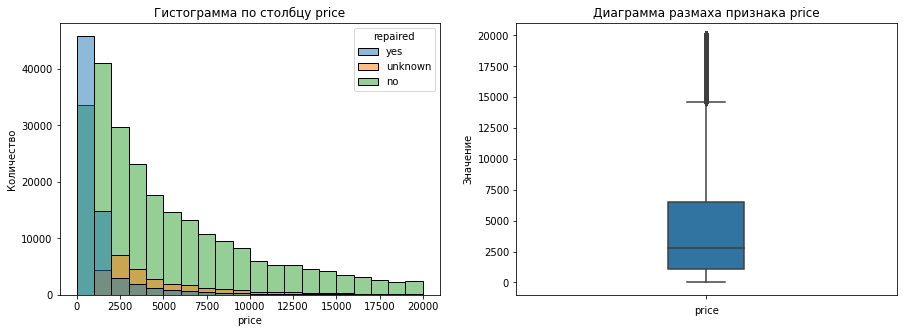

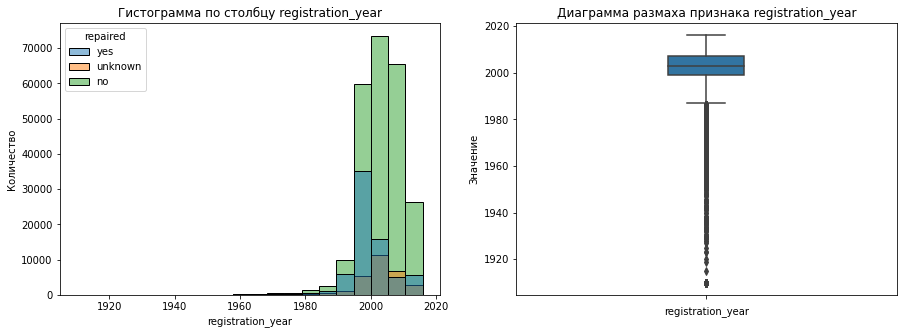

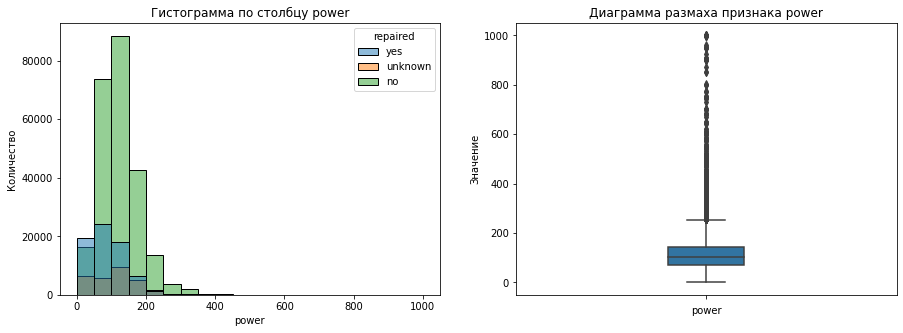

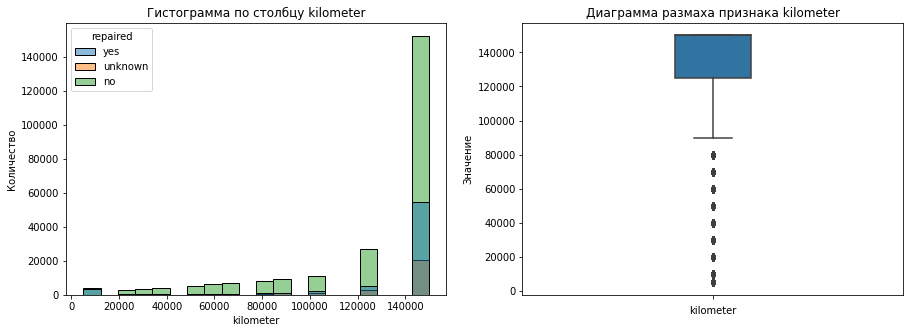

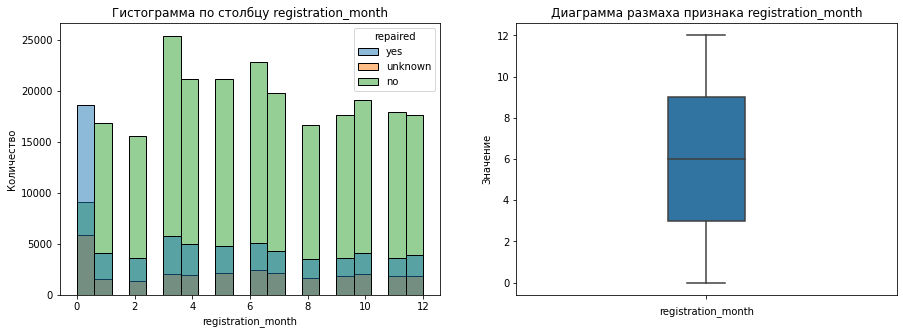

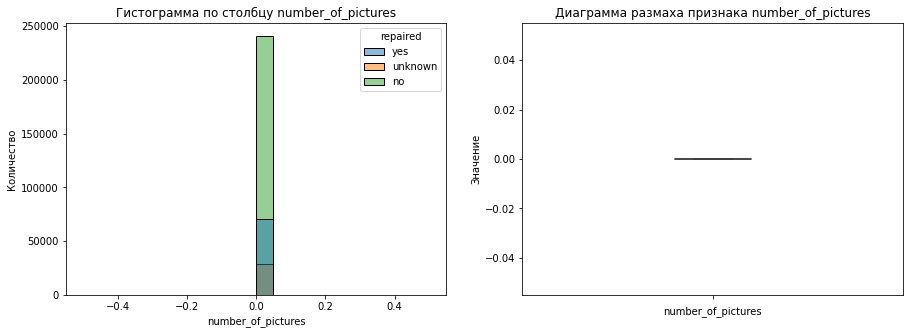

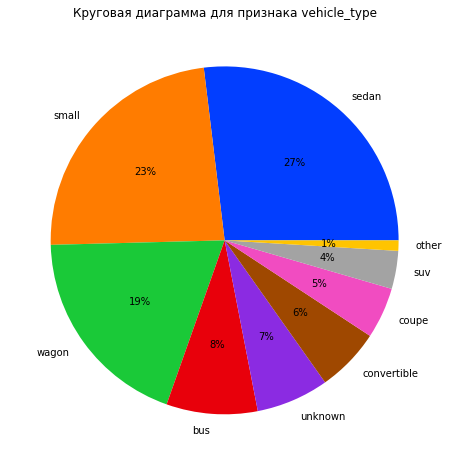

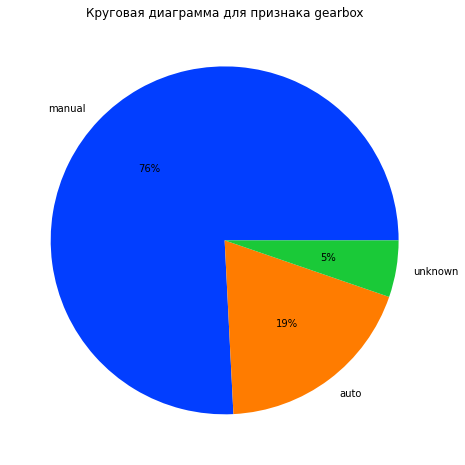

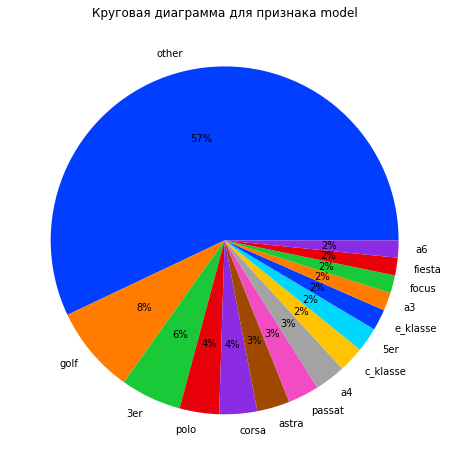

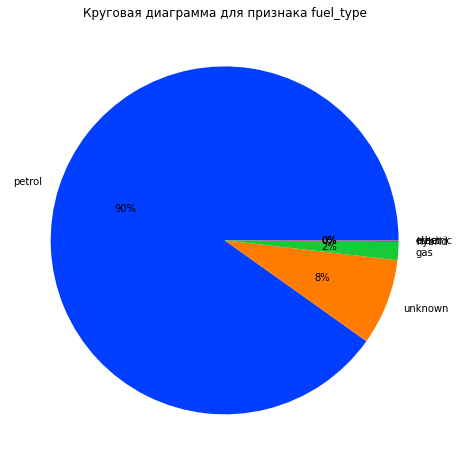

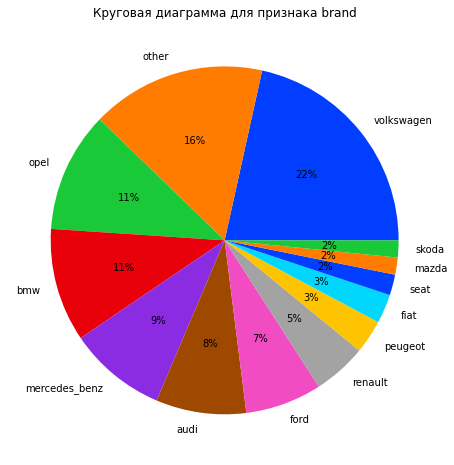

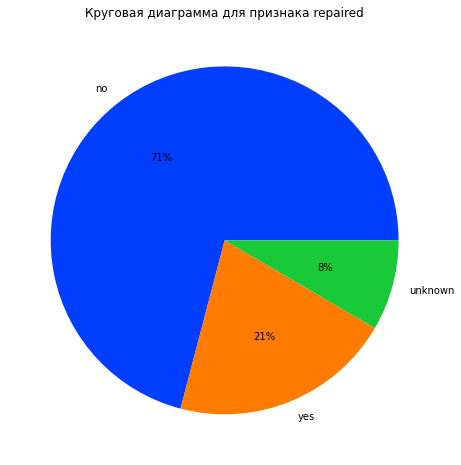

In [ ]:
lunge_analysis(primary_data, num_columns, cat_columns, 'repaired')

Распределения признаков скорректированы, слишком аномальные значения удалены.

In [ ]:
primary_data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,other,125000,8,petrol,other,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,other,90000,7,petrol,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на количество машин с ценой 0:

In [ ]:
primary_data.loc[primary_data['price']==0]['price'].count()

9993

Таких машин достаточно много. Посмотрим на несколько таких случаев:

In [ ]:
primary_data.loc[primary_data['price']==0].head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,yes,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
115,2016-03-20 18:53:27,0,small,1999,unknown,0,other,5000,0,petrol,volkswagen,yes,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22


Среди таких машин встречаются случаи, которые не ремонтировались и которые с мощностью 0. Вероятно, это либо полностью сломанные машины либо ошибки при подаче объявлений.

Удалим из модели признаки, которые будут лишними при обучении.

In [ ]:
primary_data = primary_data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

Проверим ещё раз на наличие полных дубликатов:

In [ ]:
primary_data.duplicated().sum()

28622

После всех обработок получилось много дубликатов, но меньше 10%. Удалим их.

In [ ]:
primary_data = primary_data.drop_duplicates(ignore_index = True)

In [ ]:
primary_data.duplicated().sum()

0

In [ ]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310870 entries, 0 to 310869
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               310870 non-null  int64 
 1   vehicle_type        310870 non-null  object
 2   registration_year   310870 non-null  int64 
 3   gearbox             310870 non-null  object
 4   power               310870 non-null  int64 
 5   model               310870 non-null  object
 6   kilometer           310870 non-null  int64 
 7   registration_month  310870 non-null  int64 
 8   fuel_type           310870 non-null  object
 9   brand               310870 non-null  object
 10  repaired            310870 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.1+ MB


Все явные дубликаты удалены.

### Корреляционный анализ

Теперь посмотрим на корреляцию признаков. Создадим сперва список столбцов для анализа корреляции.

In [ ]:
corr_columns = ['price',
               'vehicle_type',
                'registration_year',
                'gearbox',
                'power',
                'model',
                'kilometer',
                'registration_month',
                'fuel_type',
                'brand',
                'repaired']

Построим тепловую карту.

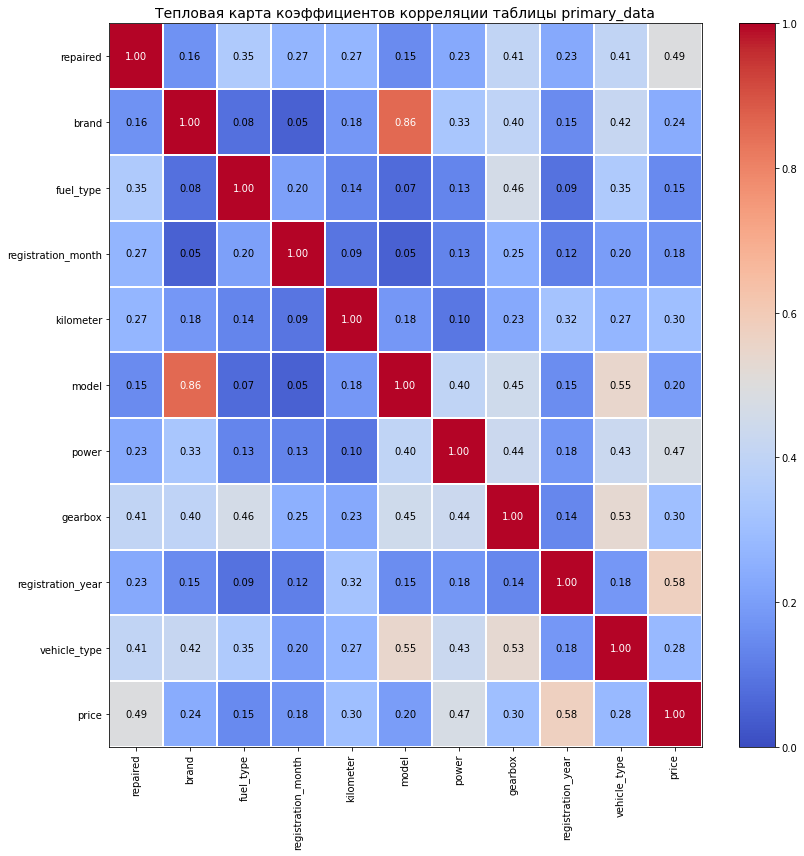

In [ ]:
phik_overview = primary_data[corr_columns].phik_matrix(interval_cols=['price',
                                                                      'registration_year',
                                                                      'power',
                                                                      'kilometer',
                                                                     'registration_month'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы primary_data",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

Рассмотрим таблицу корреляции. Относительно высокая корреляция ключевого признака со статусом ремонта (был или нет), мощностью и годом регистрации. Чуть меньше корреляция с типом коробки передач, пробегом и типов автомобиля.  
Теперь можно приступать к обучению моделей.

**Итог по разделу:**
1. Заполнены пропуски.
2. Убраны аномальные значения.
3. Проведен исследовательский анализ.
4. Проведен корреляционный анализ.

## Обучение моделей

Сохраним отдельно данные для обучения, удалив оттуда ненужные столбцы.

In [ ]:
prepared_data = primary_data[corr_columns]

In [ ]:
prepared_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,other,125000,5,petrol,audi,yes
2,9800,suv,2004,auto,163,other,125000,8,petrol,other,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,other,90000,7,petrol,skoda,no


Разобъем на данные на тренировочные и тестовые выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    prepared_data.drop('price', axis=1),
    prepared_data['price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((233152, 10), (77718, 10), (233152,), (77718,))

Подготовим методы кодирования и масштабирования признаков.

In [ ]:
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer', 'registration_month']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

Внесем нужные модели в Pipeline. Будем использовать LinearRegression и LGBMRegressor.

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для моделей
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves':[5],
        'models__max_depth':[5],
        'models__learning_rate':[0.5],
        'models__n_estimators':[50],
        'models__subsample_for_bin':[10000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

]


Подберем с помощью GridSearch наилучшую модель и вариант масштабирования.

In [ ]:
%%time
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n',grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)

# проверка работы модели на тестовой выборке
y_test_pred = grid_search.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', 'passthrough',
                                             

Время выполнения ячейки около трёх минут. Лучшая модель - LGBMRegressor, при этом RMSE получился около 1900, что соответствует требования задачи в 2500.

**Итоги по разделу:**
1. Подобрана наилучшая модель.
2. Качество наилучшей модели соответствует требованиям в RMSE < 2500.

## Анализ моделей

Выгрузим метод подготовки признаков из Pipeline.

In [ ]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

Теперь получим названия признаков после кодировки.

In [ ]:
encoder = ohe_pipe['ohe']
# обучение кодирования на тренировочных данных
encoder.fit(X_train[ohe_columns].dropna())

cat_encoder = encoder.get_feature_names_out()

num_features = ['registration_year', 'power', 'kilometer', 'registration_month']

feature_names = np.concatenate([cat_encoder, num_features])
feature_names

array(['vehicle_type_convertible', 'vehicle_type_coupe',
       'vehicle_type_other', 'vehicle_type_sedan', 'vehicle_type_small',
       'vehicle_type_suv', 'vehicle_type_unknown', 'vehicle_type_wagon',
       'gearbox_manual', 'gearbox_unknown', 'model_5er', 'model_a3',
       'model_a4', 'model_a6', 'model_astra', 'model_c_klasse',
       'model_corsa', 'model_e_klasse', 'model_fiesta', 'model_focus',
       'model_golf', 'model_other', 'model_passat', 'model_polo',
       'fuel_type_gas', 'fuel_type_hybrid', 'fuel_type_other',
       'fuel_type_petrol', 'fuel_type_unknown', 'brand_bmw', 'brand_fiat',
       'brand_ford', 'brand_mazda', 'brand_mercedes_benz', 'brand_opel',
       'brand_other', 'brand_peugeot', 'brand_renault', 'brand_seat',
       'brand_skoda', 'brand_volkswagen', 'repaired_unknown',
       'repaired_yes', 'registration_year', 'power', 'kilometer',
       'registration_month'], dtype=object)

Теперь надо модель проанализировать. При использовании SHAP время анализа занимает 5-6 часов. Чтобы избежать такого долгого ожидания обучим модель ещё раз и проанализируем её работу.

Подготовим признаки с помощью метода, выгруженного из Pipeline.

In [ ]:
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

### Анализ влияния признаков на работу модели LightGBM

Переведём данные в датасеты.

In [ ]:
train_dataset = lgb.Dataset(X_train_preprocessed, y_train)
test_dataset = lgb.Dataset(X_test_preprocessed, y_test)

Зададим параметры обучения:

In [ ]:
param = {'objective': 'regression',
        'metric':'rmse'}

Обучим.

In [ ]:
%%time
# Пришлось вводит признаки таким длинным образом, так как через переменную код падал с ошибкой.
num_round = 25
bst = lgb.train(param, train_dataset, num_round, valid_sets=[test_dataset], feature_name=['x0_convertible',
                                                                                          'x0_coupe',
                                                                                          'x0_other',
                                                                                          'x0_sedan',
                                                                                          'x0_small',
                                                                                          'x0_suv',
                                                                                          'x0_unknown',
                                                                                          'x0_wagon',
                                                                                          'x1_manual',
                                                                                          'x1_unknown',
                                                                                          'x2_5er',
                                                                                          'x2_a3',
                                                                                          'x2_a4',
                                                                                          'x2_a6',
                                                                                          'x2_astra',
                                                                                          'x2_c_klasse',
                                                                                          'x2_corsa',
                                                                                          'x2_e_klasse',
                                                                                          'x2_fiesta',
                                                                                          'x2_focus',
                                                                                          'x2_golf',
                                                                                          'x2_other',
                                                                                          'x2_passat',
                                                                                          'x2_polo',
                                                                                          'x3_gas',
                                                                                          'x3_hybrid',
                                                                                          'x3_other',
                                                                                          'x3_petrol',
                                                                                          'x3_unknown',
                                                                                          'x4_bmw',
                                                                                          'x4_fiat',
                                                                                          'x4_ford',
                                                                                          'x4_mazda',
                                                                                          'x4_mercedes_benz',
                                                                                          'x4_opel',
                                                                                          'x4_other',
                                                                                          'x4_peugeot',
                                                                                          'x4_renault',
                                                                                          'x4_seat',
                                                                                          'x4_skoda',
                                                                                          'x4_volkswagen',
                                                                                          'x5_unknown',
                                                                                          'x5_yes',
                                                                                          'registration_year',
                                                                                          'power',
                                                                                          'kilometer',
                                                                                          'registration_month'
                                                                                         ])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 233152, number of used features: 47
[LightGBM] [Info] Start training from score 4482.384470
[1]	valid_0's rmse: 4207.28
[2]	valid_0's rmse: 3926.1
[3]	valid_0's rmse: 3678.65
[4]	valid_0's rmse: 3465.03
[5]	valid_0's rmse: 3276.05
[6]	valid_0's rmse: 3110.13
[7]	valid_0's rmse: 2967.19
[8]	valid_0's rmse: 2839.81
[9]	valid_0's rmse: 2731.32
[10]	valid_0's rmse: 2633.92
[11]	valid_0's rmse: 2551.17
[12]	valid_0's rmse: 2480.01
[13]	valid_0's rmse: 2415.4
[14]	valid_0's rmse: 2361.22
[15]	valid_0's rmse: 2310.77
[16]	valid_0's rmse: 2269.11
[17]	valid_0's rmse: 2230.01
[18]	valid_0's rmse: 2197.48
[19]	valid_0's rmse: 2167.69
[20]	valid_0's rmse: 2138.85
[21]	valid_0's rmse

Достигнутое RMSE после 25 итераций - 2018.

Проанализируем модель

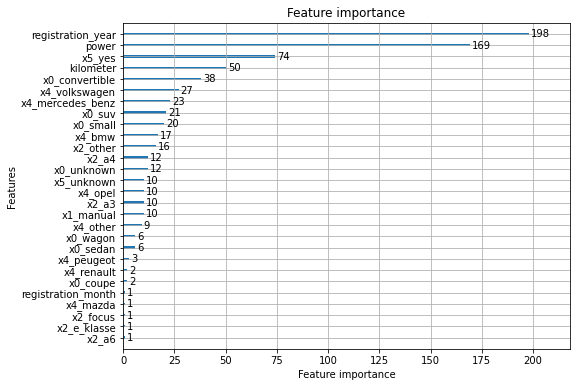

In [ ]:
lgb.plot_importance(bst, figsize=(8,6))
plt.show()

Как видно, наибольший вклад в модель имеет год регистрации автомобиля. Второй по значимости признак - мощность. Факт ремонта тоже значим для модели и он находиться на третьем месте.

### Анализ времени работы моделей

Теперь посмотрим на время обучения и предсказания каждой модели, включая dummy модель.

In [ ]:
dummy_model = DummyRegressor(strategy='mean')

In [ ]:
model_lbm = LGBMRegressor(learning_rate=0.5,
                          max_depth=5,
                          n_estimators=50,
                          num_leaves=5,
                          random_state=RANDOM_STATE,
                          subsample_for_bin=10000)

In [ ]:
model_lin = LinearRegression()

In [ ]:
model_list = [model_lbm, model_lin, dummy_model]

In [ ]:
time_fit = []
time_pred = []
RMSE_list = []

In [ ]:
for model in model_list:
    start = time()
    model.fit(X_train_preprocessed, y_train)
    end = time()
    time_fit.append(end-start)
    start = time()
    pred = model.predict(X_test_preprocessed)
    end = time()
    time_pred.append(end-start)
    RMSE_list.append(root_mean_squared_error(y_test, pred))

Сведём всё в один датафрейм

In [ ]:
comparison_models = pd.DataFrame(data={'time_fit':time_fit, 'time_pred':time_pred, 'RMSE':RMSE_list},
                                 index=['model_lbm', 'model_lin', 'dummy_model'])

In [ ]:
comparison_models

,time_fit,time_pred,RMSE
model_lbm,1.953203,0.107388,1984.935263
model_lin,0.897612,0.003499,3121.768732
dummy_model,0.001210,0.000216,4531.039424


Как видно из таблицы, самая медленная модель - LGBMRegressor, однако она же и с самой высокой точностью. Её метрика почти в два раза ниже, чем у линейной регрессии. Обе модели показали результаты значительно лучше, чем dummy модель, что говорит о корректности подготовки данных.

**Итоги по разделу:**
1. LightGBM работает медленне, чем линейная регрессия.
2. Линейная регрессия хуже по качеству чем LightGBM и не соответствует требованиям задания.

## Выводы

**В рамках работы выполнено:**
1. Подготовлены данные, удалены дубликаты, заполнены пропуски, устраненны аномалии.
2. Проведен исследовательский анализ данных.
3. Проведен корреляционный анализ данных.
4. Обучены две модели LGBMRegressor и LinearRegression.
5. Проанализирована скорость работы модели и их качество.

**Результаты работы:**
1. LGBMRegressor при обучении в Pipeline показал лучшие результаты, чем LinearRegression. Так, у LGBMRegressor RMSE составило около 1900, что соответствует требуемому значению.
2. RMSE для LinearRegression оказался значительно выше и составил около 3000. Значение не соответствует требованиям.
3. LGBMRegressor обучается медленне, чем LinearRegression, но дает лучшие результаты.
4. При прогнозе цены на автомобиль наибольшее значение имеют следующие признаки: год регистрации, мощность и факт ремонта автомобиля.

**Предложения для улучшения качества модели:**
1. Уточнить статус ремонта у машин, у которых он не был указан.
2. Добавить дополнительные признаки, к примеру, количество владельцев, состояние салона и кузова.